<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Simple_Silicon_atomic_structure_and_analysis_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description of Atoms module and analysis

# Table of contents
1. Creating Silicon Atoms class
2. Basic Atoms properties
3. Atoms class to_dict and from_dict methods
4. Making supercells
5. Spacegroup information and conventional structure
6. Making point-defect vacancy
7. Making surface structure
8. Making interfaces
9. Neighborhood analysis
10. X-ray diffractio (XRD) patterns
11. Obtaining machine-learning descriptors
12. Get an atomistic graph

In [6]:
!pip install jarvis-tools spglib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00


### A crystal structure is defined by lattice-matrix, atomic coordinates and element types. As an example, let's create Siliocn crystal structure. We need to to import Atoms class from jarvis-tools to do that.

In [7]:
# If you don't have jarvis-tools package installed, try
# !pip install jarvis-tools
# and restart runtime for your notebook
from jarvis.core.atoms import Atoms

In [8]:
#Silicon crystal structure example. These crystal-structure data are generally obtained from XRD-type experiments.
box = [[2.715, 2.715, 0], [0, 2.715, 2.715], [2.715, 0, 2.715]]
coords = [[0, 0, 0], [0.25, 0.25, 0.25]]
elements = ["Si", "Si"]
Si = Atoms(lattice_mat=box, coords=coords, elements=elements)

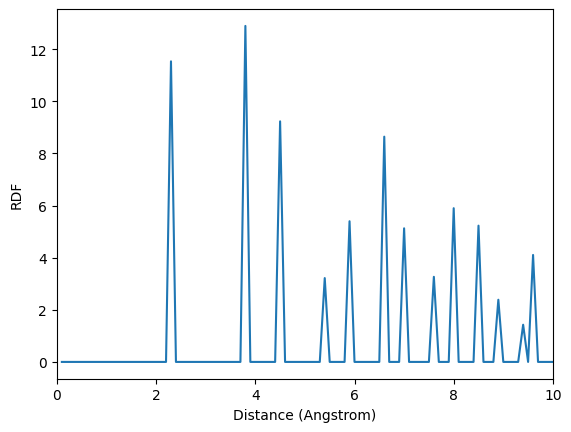

In [9]:
# RDF
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
atoms=Si

dists=[]
for i in atoms.get_all_neighbors(r=10):
    for j in i:
      dists.append(j[2])
dists=np.array(dists)
hist, bins = np.histogram(dists, bins=np.arange(0.1, 10.2, 0.1))
number_density = atoms.num_atoms / atoms.volume
shell_vol = (
            4.0
            / 3.0
            * np.pi
            * (np.power(bins[1:], 3) - np.power(bins[:-1], 3))
        )

rdf = (
            hist / shell_vol / number_density / atoms.num_atoms
        )
plt.plot(bins[:-1], rdf)
plt.xlim([0,10])
plt.xlabel('Distance (Angstrom)')
plt.ylabel('RDF')
plt.show()

### Once the Atoms class is created, several properties can be calculated. Examples are given below:

In [10]:
print ('volume',Si.volume)
print ('density in g/cm3', Si.density)
print ('composition as dictionary', Si.composition)
print ('Chemical formula', Si.composition.reduced_formula)
print ('Spacegroup info', Si.spacegroup())
print ('lattice-parameters', Si.lattice.abc, Si.lattice.angles)
print ('packing fraction',Si.packing_fraction)
print ('number of atoms',Si.num_atoms)
print ('Center of mass', Si.get_center_of_mass())
print ('Atomic number list', Si.atomic_numbers)

volume 40.02575174999999
density in g/cm3 2.3303545408113413
composition as dictionary OrderedDict([('Si', 2)])
Chemical formula Si
Spacegroup info Fd-3m (227)
lattice-parameters [3.83959, 3.83959, 3.83959] [60.0, 60.0, 60.0]
packing fraction 0.27858
number of atoms 2
Center of mass [0.67875 0.67875 0.67875]
Atomic number list [14, 14]


In [11]:
# Print Atoms class in POSCAR format
print (Si)

System
1.0
2.715 2.715 0.0
0.0 2.715 2.715
2.715 0.0 2.715
Si 
2 
direct
0.0 0.0 0.0 Si
0.25 0.25 0.25 Si



### For databases purposes, it maybe important to store the Atoms class as a dictionary and then reloading the dictionary as Atoms object. An example is given below:

In [12]:
Si.to_dict()

OrderedDict([('lattice_mat',
              [[2.715, 2.715, 0.0], [0.0, 2.715, 2.715], [2.715, 0.0, 2.715]]),
             ('coords', [[0.0, 0.0, 0.0], [0.25, 0.25, 0.25]]),
             ('elements', ['Si', 'Si']),
             ('abc', [3.83959, 3.83959, 3.83959]),
             ('angles', [60.0, 60.0, 60.0]),
             ('cartesian', False),
             ('props', ['', ''])])

In [13]:
d = Si.to_dict()
new_atoms = Atoms.from_dict(d)

Making a supercells: there are two methods

In [14]:
supercell_1 = Si.make_supercell([2,2,2])
supercell_2 = Si.make_supercell_matrix([[2,0,0],[0,2,0],[0,0,2]])
supercell_1.density == supercell_2.density

True

### Many tensor-like material properties such as elastic constants require conventional cell representations, which can be obtained as follows:

In [15]:
from jarvis.analysis.structure.spacegroup import Spacegroup3D

spg = Spacegroup3D(Si)
Si_cvn = spg.conventional_standard_structure
print ('Number of atoms in the conventional cell', Si_cvn.num_atoms)
print ('Wycoff multoplicity in the primitive-cell', spg._dataset["wyckoffs"])

Number of atoms in the conventional cell 8
Wycoff multoplicity in the primitive-cell ['b', 'b']


/usr/local/lib/python3.10/dist-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['wyckoffs']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


In [16]:
# Example to create Atoms object from POSCAR format file
from jarvis.io.vasp.inputs import Poscar
import urllib
url = 'https://raw.githubusercontent.com/usnistgov/jarvis/v2020.6.9/jarvis/examples/vasp/SiOptb88/POSCAR'
webf = urllib.request.urlopen(url)
txt = webf.read()
f = open('POSCAR', 'wb')
f.write(txt)
f.close()

pos = Poscar.from_file('POSCAR').atoms
print (pos)

System
1.0
3.348898 0.0 1.933487
1.116299 3.157372 1.933487
0.0 0.0 3.866975
Si 
2 
direct
0.875 0.875 0.875 Si
0.125 0.125 0.125 Si



### Realistic materials contain several types of point, line, surface and volume defects. Examples to create point-defects and surfaces are shown below:

In [17]:
from jarvis.analysis.defects.vacancy import Vacancy

vacs = Vacancy(atoms=Si).generate_defects(enforce_c_size=10.0) #enforces cell-size to be close to 10 Angstroms
print (len(vacs), Atoms.from_dict(vacs[0].to_dict()["defect_structure"]).num_atoms)
# We find that there are only one unique point vacanc available based on Wycoff-position information

1 53


In [18]:
from jarvis.analysis.defects.surface import wulff_normals, Surface

# Let's create (1,1,1) surface with three layers, and vacuum=18.0 Angstrom
# We center it around origin so that it looks good during visualization
surface_111 = Surface(atoms=Si, indices=[1, 1, 1], layers = 3, vacuum = 18 ).make_surface().center_around_origin()

In [19]:
print (surface_111)

System
1.0
7.679179643685906 0.0 0.0
3.8395898218429525 6.650364651656329 0.0
0.0 0.0 27.405035885099004
Si 
24 
direct
-0.3333332867891879 -0.08333339162161049 0.399903978739414 Si
0.33333347325402396 -0.41666695810805277 0.5142994316086551 Si
1.000000233297236 -0.7500005245944953 0.6286948844778962 Si
-0.5000002564972453 0.7500005245944952 0.37130511552210377 Si
0.16666650354596688 0.41666695810805277 0.48570056839134484 Si
0.8333332635891788 0.08333339162161042 0.6000960212605859 Si
-0.33333347325402407 0.4166669581080528 0.3999039787394141 Si
0.3333332867891878 0.08333339162161053 0.5142994316086551 Si
1.0000000468323997 -0.2500001748648319 0.6286948844778962 Si
-0.500000070032409 0.2500001748648317 0.37130511552210377 Si
0.16666669001080284 -0.08333339162161055 0.4857005683913449 Si
0.833333450054015 -0.41666695810805304 0.6000960212605859 Si
-0.8333332635891787 -0.08333339162161042 0.3999039787394141 Si
-0.16666650354596677 -0.41666695810805277 0.5142994316086551 Si
0.50000025649

### For practical applications, materials are generally used as heterostructures. We can use the following as an example to make Si(111)-Si(111) interface

In [20]:
from jarvis.analysis.interface.zur import ZSLGenerator, mismatch_strts, get_hetero,make_interface

film = Surface(atoms=Si, indices=[1, 1, 1], layers = 3, vacuum = 18 ).make_surface().center_around_origin()
substrate = Surface(atoms=Si, indices=[1, 1, 1], layers = 3, vacuum = 18 ).make_surface().center_around_origin()
info = make_interface(film=film, subs=substrate)['interface'].center(vacuum=18)

mismatch_u,mismatch_v 0.0 0.0


In [21]:
info

System
1.0
7.67918 -0.0 -0.0
3.83959 -6.65036 -0.0
-0.0 -0.0 -53.10755382764851
Si 
48 
direct
0.4166666784107982 -0.08333339162161049 0.6567512250352295 bottom
-0.24999970870274071 -0.7500005245944951 0.5855042367929755 bottom
-0.25000026809724957 0.7500005245944951 0.4526836319293685 bottom
-0.5833334616540194 0.4166669581080527 0.5117150118687493 bottom
-0.9166666552107886 0.08333339162161042 0.5707463918081302 bottom
-0.08333348485402856 0.4166669581080527 0.4674414769142137 bottom
-0.416666678410798 0.0833333916216105 0.5264728568535947 bottom
-0.7499998719675676 -0.25000017486483184 0.5855042367929755 bottom
0.24999989516757726 0.25000017486483167 0.4526836319293685 bottom
-0.0833332983891923 -0.0833333916216105 0.5117150118687495 bottom
0.0833334848540286 -0.4166669581080527 0.5264728568535947 bottom
-0.41666649194596195 -0.416666958108053 0.5707463918081302 bottom
0.5833334616540193 -0.4166669581080527 0.5264728568535947 bottom
0.2500002680972498 -0.7500005245944951 0.585504236

### Atomic-neighborhood analysis

In [22]:
from jarvis.analysis.structure.neighbors import NeighborsAnalysis

nb = NeighborsAnalysis(Si)

In [23]:
bins_rdf, rdf, nbs = nb.get_rdf() #Global Radial distribution function
adfa, bins_a = nb.ang_dist_first() #Angular distribution function upto first neighbor
adfb, bins_b = nb.ang_dist_second() #Angular distribution function upto second neighbor
ddf, bins_d = nb.get_ddf() #Dihedral distribution function upto first neighbor

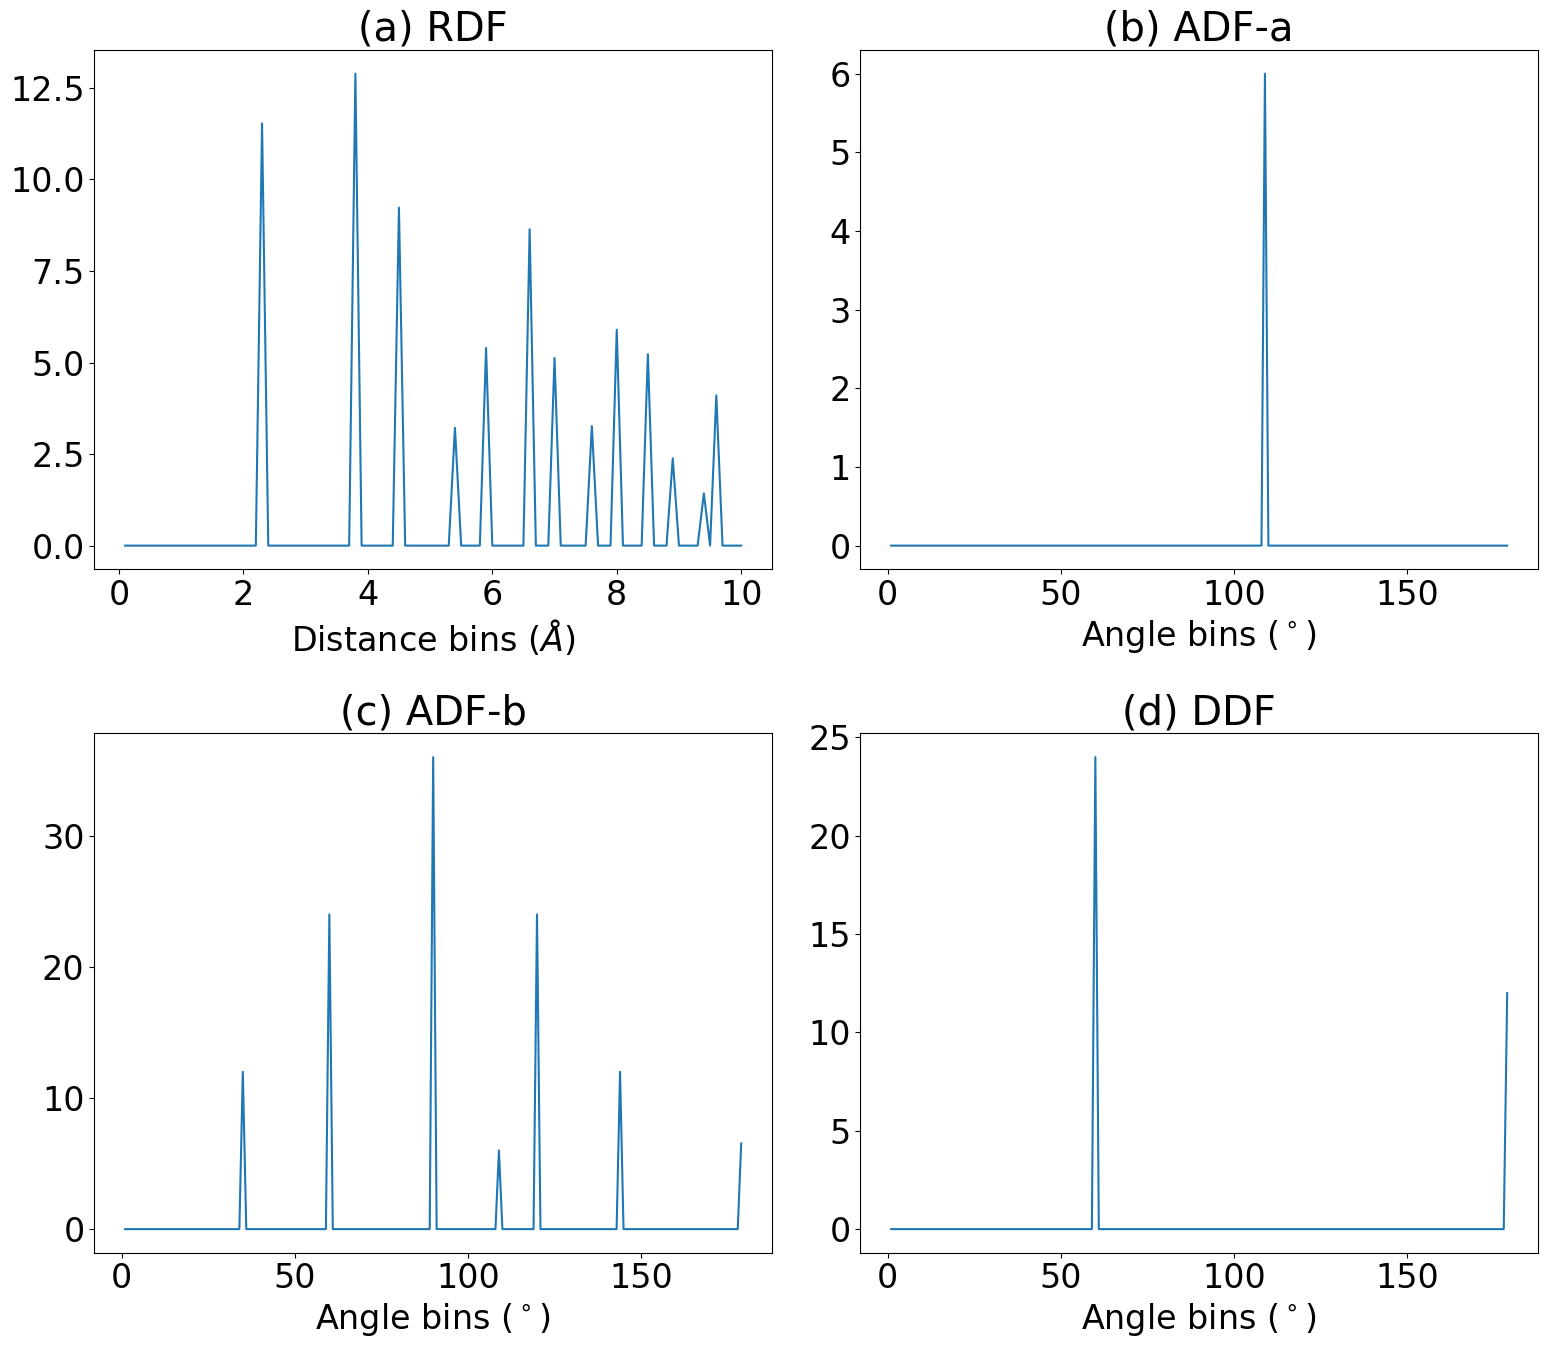

In [24]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

the_grid = GridSpec(2, 2)
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(16,14))

plt.subplot(the_grid[0, 0])
plt.title('(a) RDF')
plt.plot(bins_rdf, rdf)
plt.xlabel(r'Distance bins ($\AA$)')

plt.subplot(the_grid[0, 1])
plt.title('(b) ADF-a')
plt.plot(bins_a[:-1], adfa)
plt.xlabel(r'Angle bins ($^\circ$)')

plt.subplot(the_grid[1, 0])
plt.title('(c) ADF-b')
plt.plot(bins_b[:-1], adfb)
plt.xlabel(r'Angle bins ($^\circ$)')

plt.subplot(the_grid[1, 1])
plt.title('(d) DDF')
plt.plot(bins_d[:-1], ddf)
plt.xlabel(r'Angle bins ($^\circ$)')
plt.tight_layout()

### X-ray diffraction

In [25]:
from jarvis.analysis.diffraction.xrd import XRD
theta,d_hkls,intens = XRD().simulate(atoms=Si)

<BarContainer object of 12 artists>

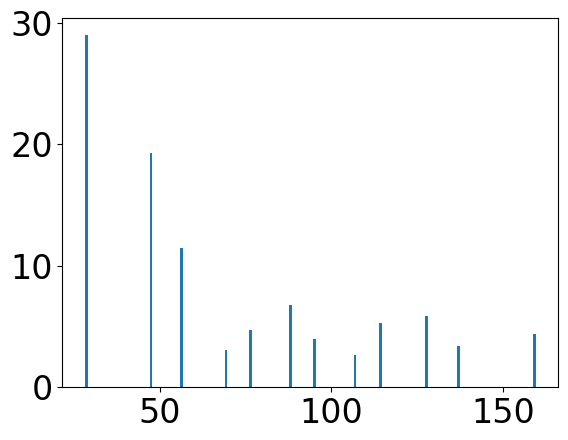

In [26]:
plt.bar(theta,intens)

In [27]:
from jarvis.core.spectrum import Spectrum
import numpy as np
def gaussian(theta2, alpha, fwhm):

    """
    Gaussian function for profiling peaks
    """

    tmp = ((alpha - theta2)/fwhm)**2
    return np.exp(-4*np.log(2)*tmp)

def get_profile(fwhm=0.1,min2theta=0,max2theta=180,res=0.02,two_thetas=[],intensities=[]):
    N = int((max2theta-min2theta)/res)
    px = np.linspace(min2theta, max2theta, N)
    py = np.zeros((N))
    for two_theta, intensity in zip(two_thetas, intensities):
        tmp = gaussian(two_theta, px, fwhm)
        py += intensity * tmp
    py /= np.max(py)
    return px,py

px,py=get_profile(two_thetas=theta,intensities=intens)

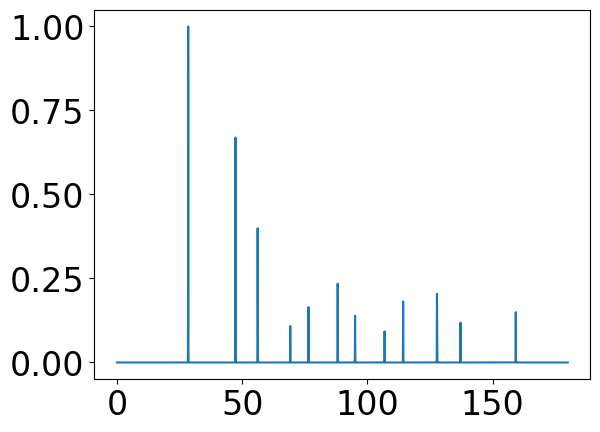

In [28]:
plt.plot(px,py)

### Getting CFID descriptors: We can convert the chemo-physical information in the Atoms class to CFID features that can be used in Machine-learning

In [29]:
from jarvis.ai.descriptors.cfid import CFID

cfid = CFID(Si)
feature_names = cfid.get_comp_descp(print_names=True)
feature_values = cfid.get_comp_descp().tolist()

In [30]:
print (feature_names[0], feature_values[0], len(feature_names), len(feature_values) )

bp_mult_atom_rad 3490.3 1557 1557


Get an atomistic graph

In [39]:
!pip uninstall dgl -y
!pip install -q dgl -f https://data.dgl.ai/wheels/torch-2.1/repo.html


Found existing installation: dgl 1.1.1
Uninstalling dgl-1.1.1:
  Successfully uninstalled dgl-1.1.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [40]:
from jarvis.core.graphs import Graph
g,lg = Graph.atom_dgl_multigraph(atoms=Si)

In [41]:
g #graph

Graph(num_nodes=2, num_edges=56,
      ndata_schemes={'atom_features': Scheme(shape=(92,), dtype=torch.float32)}
      edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)})

In [42]:
lg #line graph

Graph(num_nodes=56, num_edges=1520,
      ndata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(), dtype=torch.float32)})

In [43]:
g.ndata

{'atom_features': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.]])}